# Mapping public green areas in Manchester with geopandas

## Context & aim

The benefits of having public green areas around when living in a densily populated city are many, from encouraging exercise or providing spaces for socializing to decreasing noise and air pollution.  

I aim to map public green areas in Manchester and how they distribute accroding to it population. Fields in Trust have done an amazing job at mapping the whole of the UK and stablishing their [green-space-index](https://www.fieldsintrust.org/green-space-index), but I aim to have my own go at it using python and geopandas.

Let's import the main libraries that we are going to need.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

import contextily as cx # map backgrounds

## Greater Manchester Boundaries

Alright. The first thing we need to do is define what the boundaries fo Manchester are. For this, I am going to use shape files that delimit district boundaries provided by [Ordenance and Survey](https://osdatahub.os.uk/downloads/open/BoundaryLine). I have downloaded the file and used Geopandas to read it from the local file.

In [3]:
# Load boundaries from local shape file
fp = 'data/boundary_lines/district_borough_unitary_region.shp'
df = gpd.read_file(fp)

This file includes all boundaries for Great Britain. We actually only need those of Manchester, so we will manually filter the areas that make Greater Manchester Combined Authority. Note that filtering a Geopandas dataframe works the same way as filtering a Pandas dataframe.

In [4]:
greater_manchester_districts = [
    'Manchester District (B)',
    'Bury District (B)',
    'Oldham District (B)',
    'Rochdale District (B)',
    'Salford District (B)',
    'Trafford District (B)',
    'Stockport District (B)',
    'Tameside District (B)',
    'Bolton District (B)',
    'Wigan District (B)',
]

# Filtering to Greater Manchester
mcr_boroughs = df[df['NAME'].isin(greater_manchester_districts)]

In [6]:
mcr_boroughs.to_crs(epsg=3857, inplace=True)

/home/neperiana/.local/share/virtualenvs/mapping_urban_green_areas-t-ZFWFtm/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<AxesSubplot:>

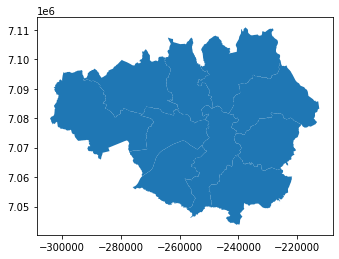

In [7]:
mcr_boroughs.plot()

In [8]:
# Define Greater Manchester
from shapely.ops import cascaded_union

greater_manchester = gpd.GeoSeries(cascaded_union(mcr_boroughs.geometry))
greater_manchester.set_crs(epsg=3857, inplace=True)

0    POLYGON ((-225561.883 7062907.534, -225555.677...
dtype: geometry

### Green spaces in Greater Manchester

In [9]:
fp = 'data/greenspace_SD/SD_GreenspaceSite.shp'
gs_sd = gpd.read_file(fp)

fp = 'data/greenspace_SJ/SJ_GreenspaceSite.shp'
gs_sj = gpd.read_file(fp)

gs = gpd.GeoDataFrame(
    pd.concat([gs_sd, gs_sj], ignore_index=True)
)

In [10]:
# Green spaces areas bu function
gs.function.value_counts()

Play Space                                4344
Playing Field                             2763
Religious Grounds                         2650
Other Sports Facility                     2126
Public Park Or Garden                     1725
Bowling Green                             1438
Allotments Or Community Growing Spaces    1395
Cemetery                                   680
Tennis Court                               659
Golf Course                                394
Name: function, dtype: int64

In [11]:
# Keeping parcs
function_types = ['Public Park Or Garden']
gs = gs[gs['function'].isin(function_types)]
gs.to_crs(epsg=3857, inplace=True)

In [12]:
# Filtering down to green spaces in greater manchester
mcr_gs = gpd.overlay(mcr_boroughs, gs, how='intersection')

<AxesSubplot:>

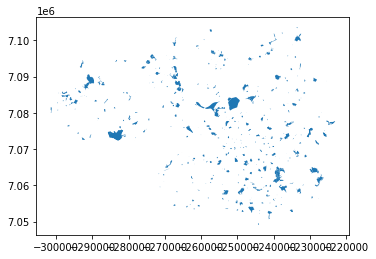

In [13]:
mcr_gs.plot()

Let's plot it using a nice background map.

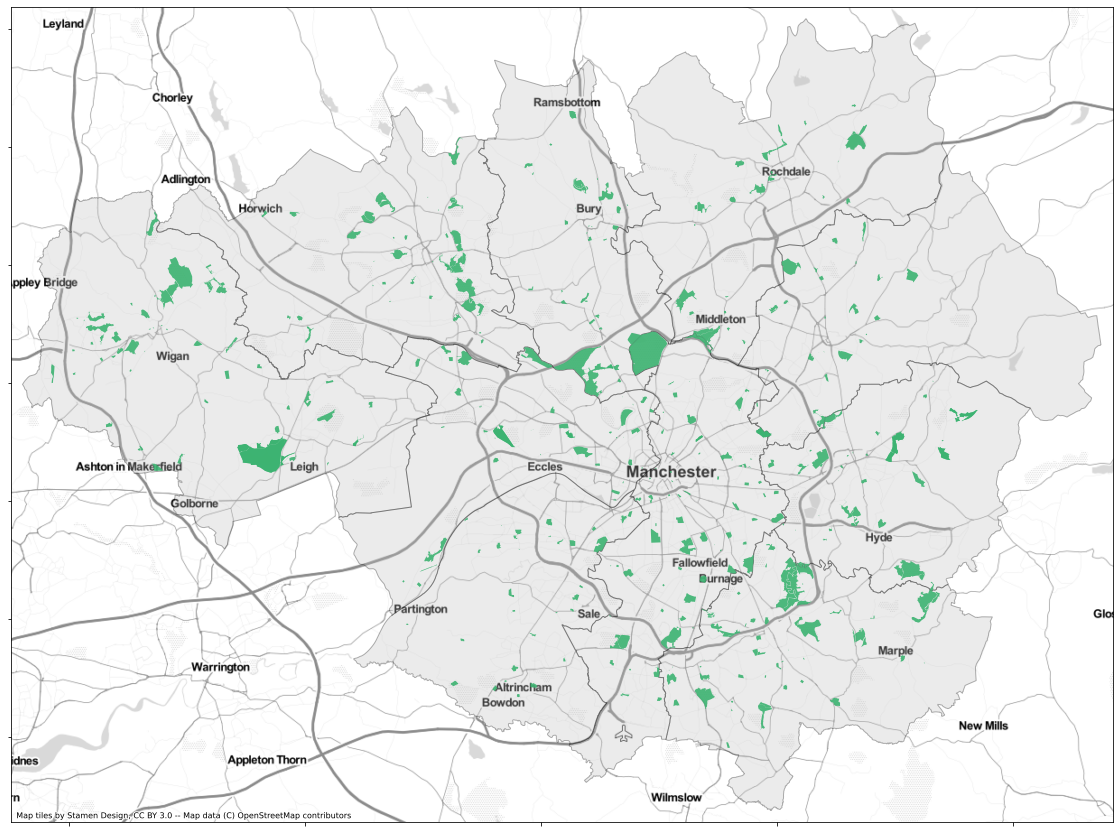

In [14]:
fig, ax = plt.subplots(figsize=(20,15))

# Define bounding box
bounds = greater_manchester.bounds
bounding_box = [
    bounds['minx'][0],
    bounds['maxx'][0],
    bounds['miny'][0],
    bounds['maxy'][0],
]

# Set bounds
ax.set_xlim(bounding_box[0]-1000, bounding_box[1] + 1000)
ax.set_ylim(bounding_box[2]-1000, bounding_box[3] + 1000)

# Plot borough borders
mcr_boroughs.plot(ax=ax, alpha=0.3, edgecolor="black", facecolor="silver")

# Plot green areas
mcr_gs.plot(ax=ax, alpha = 0.9, color="mediumseagreen")

# Add background
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)

# Remove axis 
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()

Let's zoom in to Manchester city.

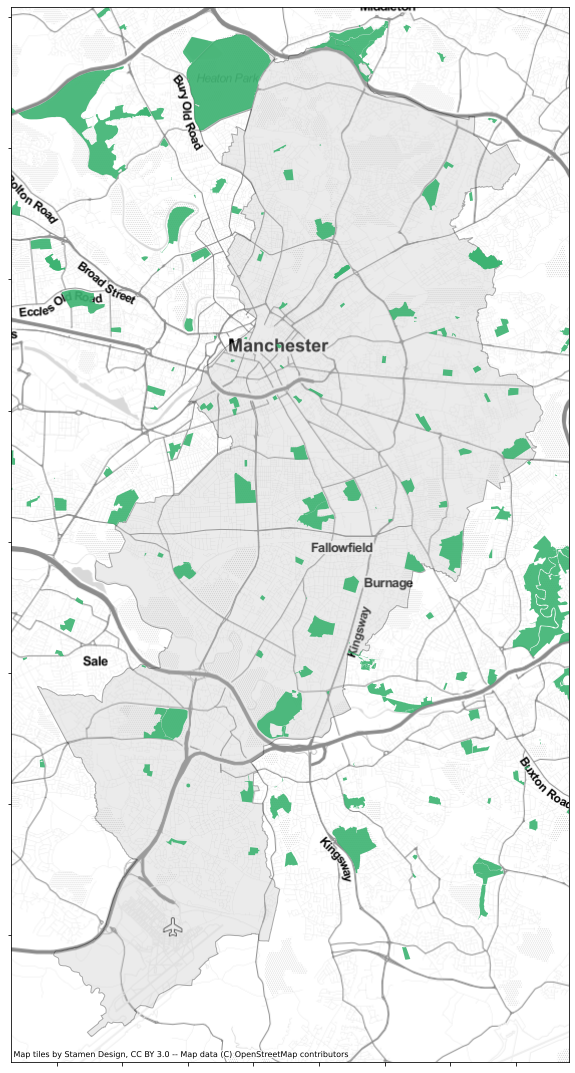

In [15]:
fig, ax = plt.subplots(figsize=(10,20))

# Define bounding box
mcr_city = mcr_boroughs[mcr_boroughs['NAME'] == 'Manchester District (B)']
bounds = mcr_city.bounds
bounding_box = [
    bounds['minx'].iloc[0],
    bounds['maxx'].iloc[0],
    bounds['miny'].iloc[0],
    bounds['maxy'].iloc[0],
]

# Set bounds
ax.set_xlim(bounding_box[0]-1000, bounding_box[1] + 1000)
ax.set_ylim(bounding_box[2]-1000, bounding_box[3] + 1000)

# Plot borough borders
mcr_city.plot(ax=ax, alpha=0.3, edgecolor="black", facecolor="silver")

# Plot green areas
mcr_gs.plot(ax=ax, alpha = 0.9, color="mediumseagreen")

# Add background
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)

# Remove axis 
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()

### Urban green space available for each postcode area

Upload postal sector data (from https://datashare.ed.ac.uk/handle/10283/2597).

In [ ]:
# UK Postal Sector boundaries
# Boundary shape files from https://datashare.ed.ac.uk/handle/10283/2597
fp = 'data/GB_Postcodes/PostalSector.shp'
ps = gpd.read_file(fp)
ps.to_crs(epsg=3857, inplace=True)

In [ ]:
# Filter by postal sectors in greater manchester
mcr_ps = gpd.overlay(mcr_boroughs, ps, how='intersection')

<AxesSubplot:>

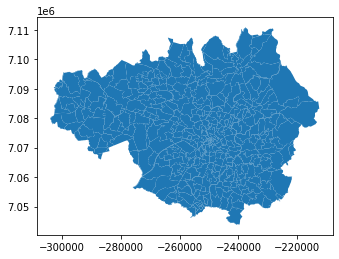

In [ ]:
mcr_ps.plot()

We want to calculate the area covered by green spaces in a 1km catchment area of each postal district.

 The libraries we’re using, however, calculate distance in a Euclidean manner, using our good old friend Pythagoras’s theorem. This is not a big problem if our analysis is constrained to the UK, since we can use “eastings and northings” as coordinates, which project the UK onto a cartesian grid, with distances measured in metres. These units may be already familiar from the markings on an Ordnance Survey map! The standardised name for this system is EPSG:27700.

In [ ]:
mcr_expanded_ps = mcr_ps.copy()

In [65]:
mcr_expanded_ps['geometry'] = mcr_expanded_ps['geometry'].apply(lambda geo: geo.buffer(2000))

In [66]:
mcr_expanded_ps['green_area_access'] = 0.0

In [67]:
mcr_expanded_ps.head()

,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,...,AnomCnt,RefPC,x,y,Sprawl,Locale,geometry,green_area_access_x,green_area_access_y,green_area_access
0,Bolton District (B),MTD,Metropolitan District,BOLTON_DISTRICT_(B),3,3,56602,18832,E08000001,13979.204,...,1,BL11EA,371743,409181,Bolton,None,"POLYGON ((-272875.209 7090433.267, -272878.781...",0.164462,1.356137,0.0
1,Bolton District (B),MTD,Metropolitan District,BOLTON_DISTRICT_(B),3,3,56602,18832,E08000001,13979.204,...,0,BL12LG,371506,409785,Bolton,None,"POLYGON ((-272188.901 7089247.047, -272287.653...",0.626389,1.890714,0.0
2,Bolton District (B),MTD,Metropolitan District,BOLTON_DISTRICT_(B),3,3,56602,18832,E08000001,13979.204,...,0,BL13HW,370890,410547,Bolton,None,"POLYGON ((-274891.149 7094211.237, -274900.110...",0.994017,2.312050,0.0
3,Bolton District (B),MTD,Metropolitan District,BOLTON_DISTRICT_(B),3,3,56602,18832,E08000001,13979.204,...,1,BL14DL,370256,409545,Bolton,None,"POLYGON ((-275817.306 7090971.865, -275846.999...",0.652228,1.401562,0.0
4,Bolton District (B),MTD,Metropolitan District,BOLTON_DISTRICT_(B),3,3,56602,18832,E08000001,13979.204,...,1,BL15EA,368790,410028,Bolton,None,"POLYGON ((-278686.285 7093630.783, -278502.357...",1.334236,2.619397,0.0


In [68]:
for i, postal_sectors in mcr_expanded_ps.iterrows():
    for j, green_space in enumerate(mcr_gs['geometry']):
        green_area_in_postal_sector = postal_sectors['geometry'].intersection(green_space)
        mcr_expanded_ps.at[i, 'green_area_access'] += green_area_in_postal_sector.area / 10**6

In [69]:
mcr_expanded_ps = mcr_expanded_ps[['RefPC','green_area_access']]

In [70]:
mcr_expanded_ps.sort_values(by='green_area_access', ascending=False).head(10)


,RefPC,green_area_access
3196,WN74ET,14.696326
3151,WA31DP,14.524315
3195,WN73JA,12.877634
1070,M250EG,8.580045
1083,M250EG,8.580045
1074,M250EG,8.580045
1075,M250EG,8.580045
1076,M250EG,8.580045
1077,M250EG,8.580045
1078,M250EG,8.580045


In [71]:
mcr_ps = pd.merge(
    mcr_ps,
    mcr_expanded_ps,
    how='left',
    on='RefPC',
)

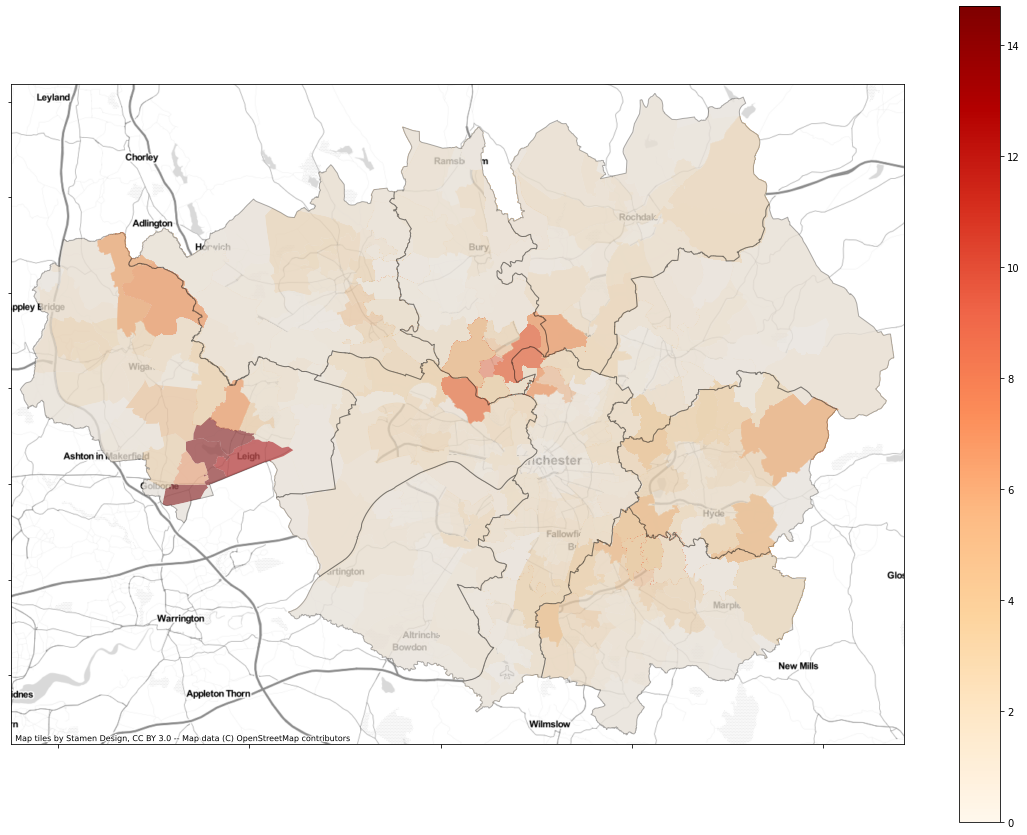

In [75]:
fig, ax = plt.subplots(figsize=(20,15))

# Define bounding box
bounds = greater_manchester.bounds
bounding_box = [
    bounds['minx'][0],
    bounds['maxx'][0],
    bounds['miny'][0],
    bounds['maxy'][0],
]

# Set bounds
ax.set_xlim(bounding_box[0]-1000, bounding_box[1] + 1000)
ax.set_ylim(bounding_box[2]-1000, bounding_box[3] + 1000)

# Plot green areas access
mcr_ps.plot(ax=ax, column='green_area_access', cmap='OrRd', alpha=0.7, legend=True)

# Plot borough borders
mcr_boroughs.plot(ax=ax, alpha=0.3, edgecolor="black", facecolor="silver")

# Add background
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)

# Remove axis 
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()